In [1]:
import os
from glob import glob
import pandas as pd
from timeit import default_timer as timer
import numpy as np
from collections import Counter
from datetime import datetime
from pathlib import Path

from pyspark.sql import SparkSession
from pyspark.sql.functions import udf,desc,row_number,col,year,month,dayofmonth,hour,dayofweek,to_timestamp,size,isnan,lit,date_format,to_timestamp,struct,expr,explode,collect_list,array
from pyspark.sql.types import MapType, StringType, IntegerType, StructType, StructField, FloatType, ArrayType, DoubleType

In [2]:
try:
    spark
except NameError:
    print('Create Spark')
    spark=SparkSession.builder.appName("").getOrCreate()

Create Spark


In [3]:
source='cuebiq'
country='MX'
start_date='2020-01-01'
end_date=datetime.today().strftime('%Y-%m-%d')

if os.getenv('CLUSTER')=='PRINCE':
    path_to_data='/scratch/spf248/covid/data' 
    path_to_fig='/scratch/spf248/covid/fig'    
    %matplotlib inline
    import matplotlib.pyplot as plt
    import seaborn as sns
else:
    path_to_data='/user/spf248/covid/data'
    path_to_fig='/home/spf248/covid/fig'
    import matplotlib as mpl
    mpl.use('Agg')
    import matplotlib.pyplot as plt
    import seaborn as sns

/share/apps/anaconda3/2019.10/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Import Aggregated Data

In [ ]:
users_profile=spark.read.parquet(os.path.join(path_to_data,source,'aggregates',country,'users_profile'))
users_profile.cache()
print('# Users:', users_profile.count()) # 21783569

In [7]:
n_pings_id_personal=spark.read.parquet(os.path.join(path_to_data,source,'aggregates',country,'n_pings_id_personal'))
n_pings_id_personal.cache()
print('# Personal Areas:', n_pings_id_personal.count()) # 34963009

DataFrame[cuebiq_id: string, point: struct<longitude:float,latitude:float>, n_pings: bigint]

In [ ]:
n_pings_id_day_hour=spark.read.parquet(os.path.join(path_to_data,source,'aggregates',country,'n_pings_id_day_hour'))
n_pings_id_day_hour.cache()
print('# Personal Areas:', n_pings_id_day_hour.count()) # 34963009

In [ ]:
n_pings_id_personal_day_hour=spark.read.parquet(os.path.join(path_to_data,source,'aggregates',country,'n_pings_id_personal_day_hour'))
n_pings_id_personal_day_hour.cache()
total_pings=n_pings_id_personal_day_hour.select('n_pings').groupby().sum().collect()[0][0]
print('# Pings at personal Locations:', total_pings) # 84668795782

In [4]:
primary_home=spark.read.parquet(os.path.join(path_to_data,source,'aggregates',country,'primary_home'))
primary_home.cache()
print('# Non-home Locations:', primary_home.count())

DataFrame[cuebiq_id: string, point: struct<longitude:float,latitude:float>, perfect_match: int]

# Secondary Personal Locations

In [8]:
personal_others=n_pings_id_personal.join(primary_home,on=['cuebiq_id','point'],how='left_anti')
personal_others.cache()
print('# Non-home Locations:', personal_others.count())

DataFrame[cuebiq_id: string, point: struct<longitude:float,latitude:float>, n_pings: bigint]

# Hours Spent At Personal Locations

In [9]:
location_name_to_data={
'all':None,
'primary':primary_home.select('cuebiq_id','point'),
'non_primary':personal_others.select('cuebiq_id','point'),
}

In [10]:
period_name_to_data={
'week':spark.sparkContext.broadcast([1,2,3,4,5]),
'weekend':spark.sparkContext.broadcast([6,7]),
}

In [ ]:
print('Hour spent at personal location')
start = timer()
hours={}
for min_days in [0,pd.date_range(start_date,end_date).shape[0]//2]:
    print('Min Days:', min_days)
    for device_type in [0,1]:
        print('Device:', device_type)
        for period_name in period_name_to_data:
            print(period_name)
            for location_name in location_name_to_data:
                print(location_name)
                if location_name=='all':
                    hours[(location_name,period_name,min_days,device_type)]=\
                    n_pings_id_day_hour.filter(n_pings_id_day_hour['dayofweek'].isin(
                    period_name_to_data[period_name].value)).join(
                    users_profile.filter(users_profile['n_personal']>1).filter(
                    users_profile['device_type']==device_type).filter(
                    users_profile['n_days']>min_days).select('cuebiq_id'),on='cuebiq_id').groupby('hour').agg(
                    {'n_pings':'sum'}).withColumnRenamed('sum(n_pings)','n_pings')
                else:
                    hours[(location_name,period_name,min_days,device_type)]=\
                    n_pings_id_personal_day_hour.filter(n_pings_id_personal_day_hour['dayofweek'].isin(
                    period_name_to_data[period_name].value)).join(
                    users_profile.filter(users_profile['n_personal']>1).filter(
                    users_profile['device_type']==device_type).filter(
                    users_profile['n_days']>min_days).select('cuebiq_id'),on='cuebiq_id').join(
                    location_name_to_data[location_name],on=['cuebiq_id','point']).groupby('hour').agg(
                    {'n_pings':'sum'}).withColumnRenamed('sum(n_pings)','n_pings')
                hours[(location_name,period_name,min_days,device_type)].write.mode("overwrite").parquet(
                os.path.join(path_to_data,source,'aggregates',country,'hours',location_name,period_name,str(min_days),str(device_type)))
print("Done in", round(timer()-start), "sec")        

# Figures

In [11]:
hours={}
for min_days in [0,pd.date_range(start_date,end_date).shape[0]//2]:
    print('Min Days:', min_days)
    for device_type in [0,1]:
        print('Device:', device_type)
        for period_name in period_name_to_data:
            print(period_name)
            for location_name in location_name_to_data:
                print(location_name)
                hours[(location_name,period_name,min_days,device_type)]=spark.read.parquet(
                os.path.join(path_to_data,source,'aggregates',country,'hours',location_name,period_name,str(min_days),str(device_type))).toPandas()

Min Days: 0
Device: 0
week
all
primary
non_primary
weekend
all
primary
non_primary
Device: 1
week
all
primary
non_primary
weekend
all
primary
non_primary
Min Days: 53
Device: 0
week
all
primary
non_primary
weekend
all
primary
non_primary
Device: 1
week
all
primary
non_primary
weekend
all
primary
non_primary


Min Days: 0
Device: 0
week
all
primary
non_primary
weekend
all
primary
non_primary
Device: 1
week
all
primary
non_primary
weekend
all
primary
non_primary
Min Days: 53
Device: 0
week
all
primary
non_primary
weekend
all
primary
non_primary
Device: 1
week
all
primary
non_primary
weekend
all
primary
non_primary


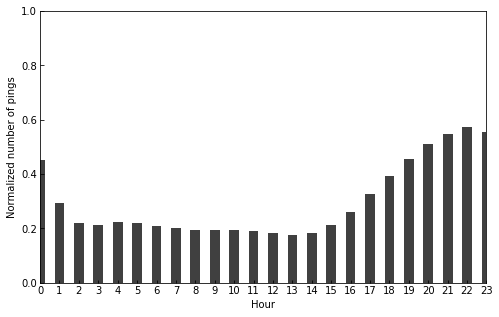

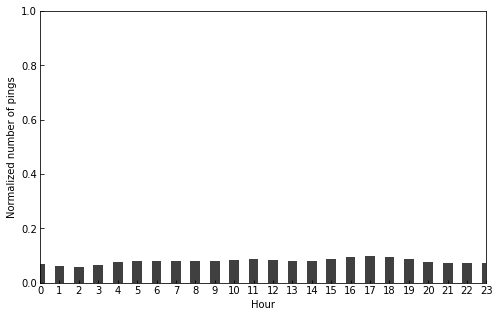

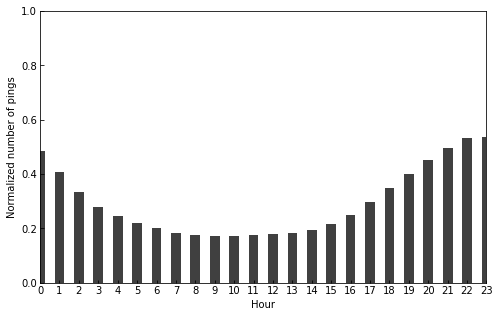

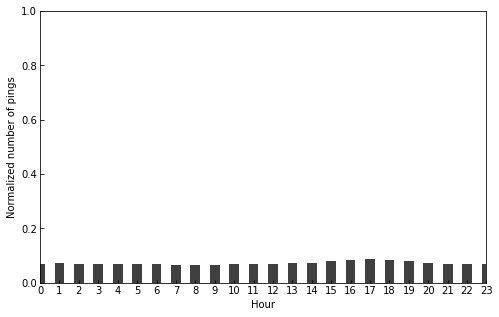

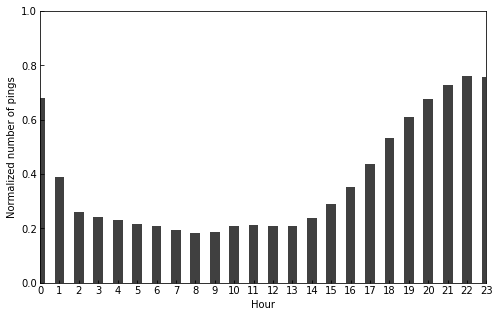

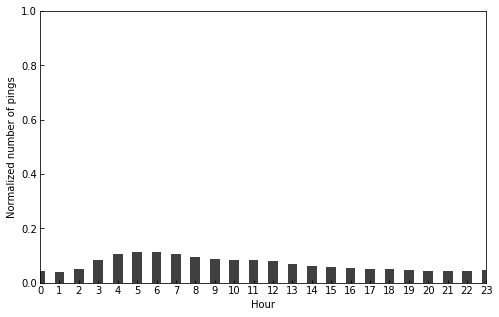

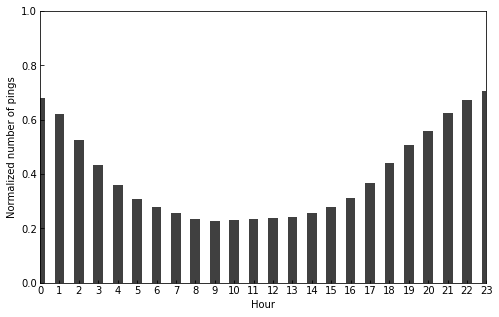

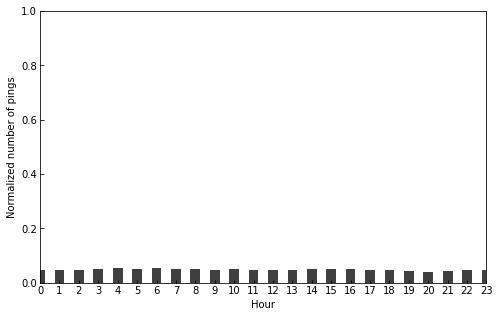

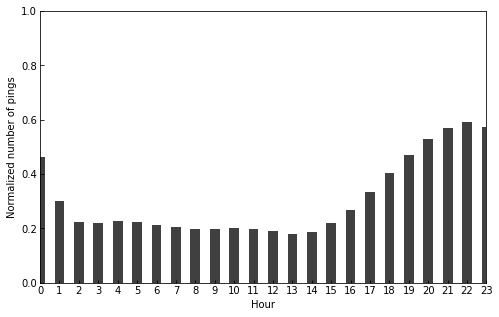

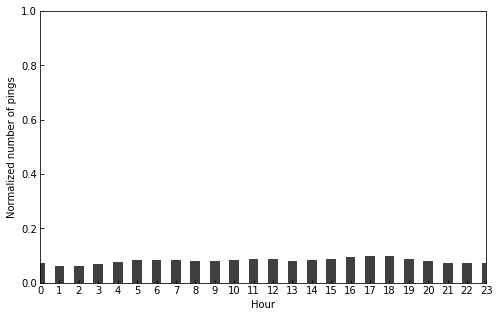

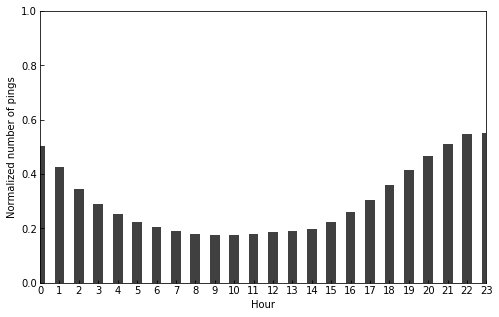

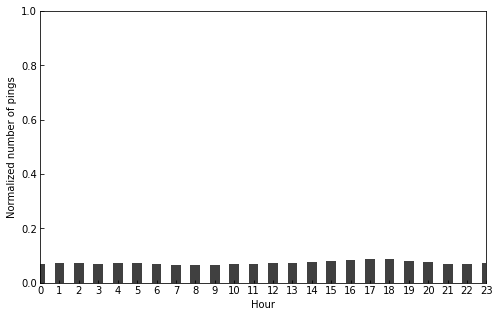

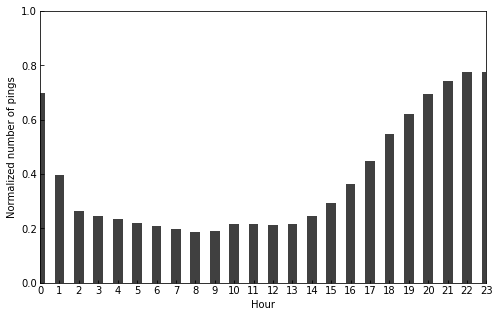

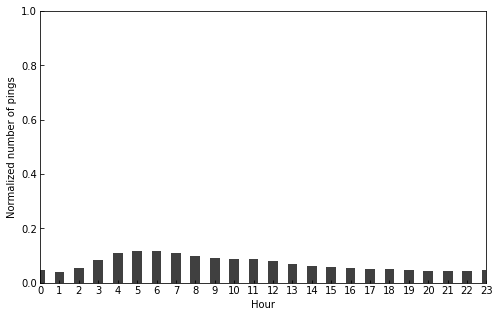

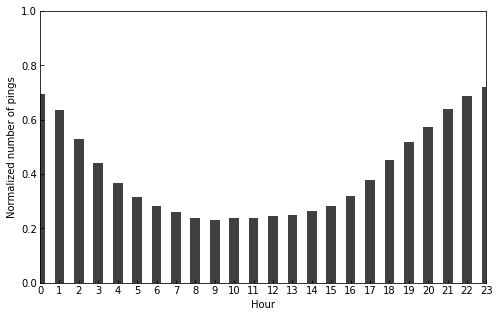

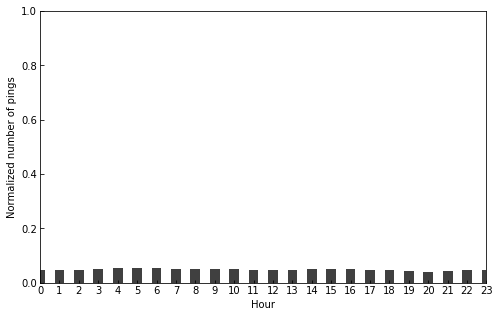

In [12]:
for min_days in [0,pd.date_range(start_date,end_date).shape[0]//2]:
    print('Min Days:', min_days)
    for device_type in [0,1]:
        print('Device:', device_type)
        for period_name in period_name_to_data:
            print(period_name)
            for location_name in location_name_to_data:
                print(location_name)
                if location_name=='all':
                    continue
            
                data=hours[(location_name,period_name,min_days,device_type)].set_index('hour')['n_pings'].sort_index().divide(
                hours[('all',period_name,min_days,device_type)].set_index('hour')['n_pings'].sort_index())
                
                fig,ax=plt.subplots(figsize=(8,5))
                data.plot(ax=ax,kind='bar',color='k',alpha=0.75)
                ax.tick_params(which='both',direction='in',pad=3)
                ax.locator_params(axis='y',nbins=5)
                plt.xticks(rotation=0)
                ax.set_xlabel('Hour')
                ax.set_ylabel('Normalized number of pings')
                ax.set_xlim([0,23])
                ax.set_ylim([0,1])
                plt.savefig(os.path.join(path_to_fig,country,'hours-'+location_name+'-'+period_name+'-device-'+str(device_type)+'-min-days-'+str(min_days)+'.pdf'),bbox_inches='tight')

In [ ]:
# Personal Locations: 34273578
# Users with personal locations: 21417460
# Home detected: 20992177
# Non-home locations: 13281401
# Non-home locations: 11624061